In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

C:\Users\jamie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jamie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jamie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jamie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv("C:\\Users\\jamie\\Untitled Folder 1\\Human_Activity_Dataset\\Seizure\\ds\\final.txt", header = None, names = columns)
df = df.dropna()
print(columns)

['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']


In [3]:
df.tail()

,user,activity,timestamp,x-axis,y-axis,z-axis
1211278,19,Sitting,1.316233e+14,9.00,-1.57,1.69;
1211279,19,Sitting,1.316234e+14,9.04,-1.46,1.73;
1211280,19,Sitting,1.316234e+14,9.08,-1.38,1.69;
1211281,19,Sitting,1.316235e+14,9.00,-1.46,1.73;
1211282,19,Sitting,1.316235e+14,8.88,-1.33,1.61;


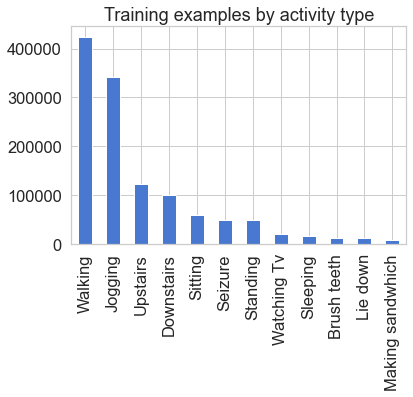

In [4]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

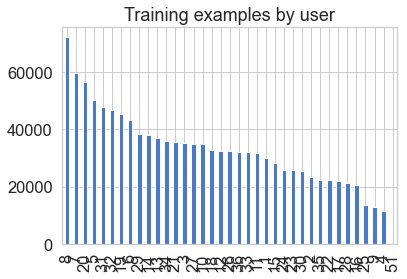

In [5]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [9]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:500]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
        
        
# Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,5,Watching Tv,8.117712e+12,2.232,7.699,3.546
1,5,Watching Tv,8.117762e+12,1.869,6.957,3.487
2,5,Watching Tv,8.117812e+12,2.251,6.255,3.589
3,5,Watching Tv,8.117862e+12,2.403,5.457,3.174
4,5,Watching Tv,8.117912e+12,2.220,4.784,2.145


C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDepreca

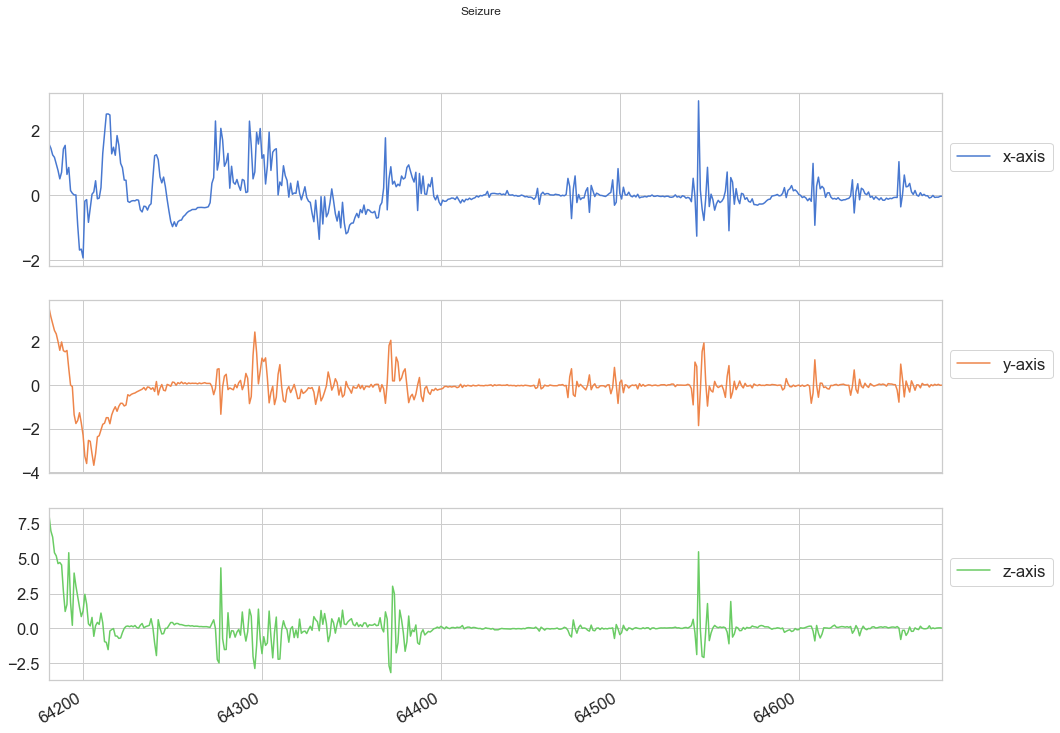

In [10]:
plot_activity("Seizure", df)


C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jamie\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDepreca

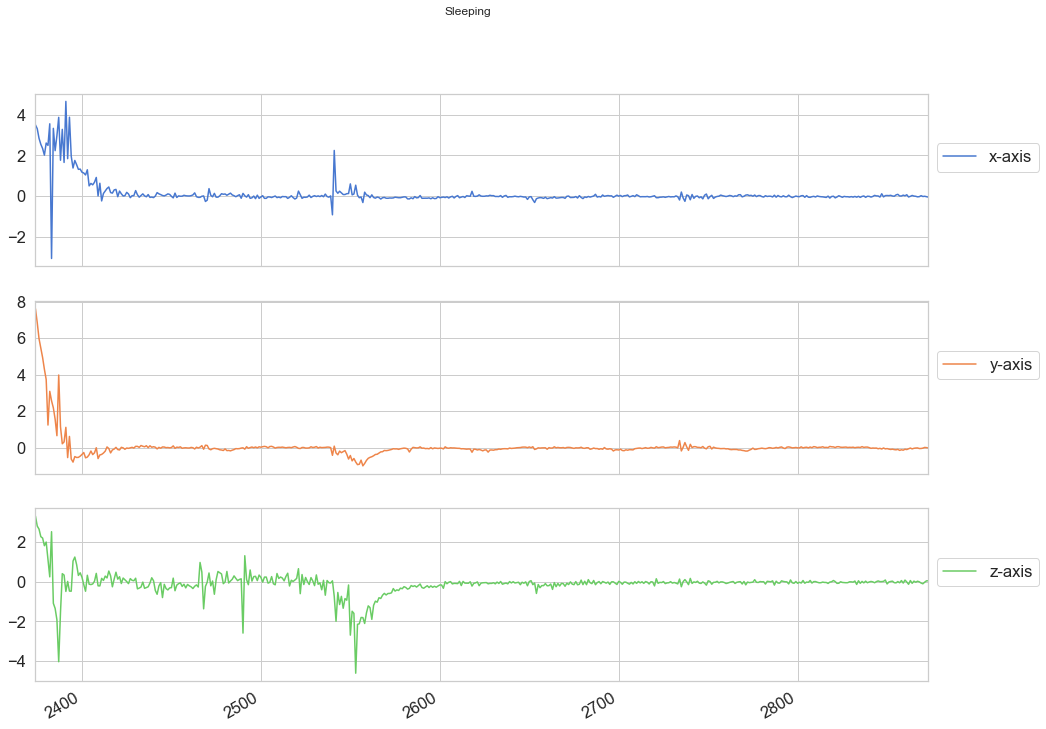

In [11]:
plot_activity("Sleeping", df)

In [12]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\jamie\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [13]:
np.array(segments).shape

(60555, 3, 200)

In [14]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [15]:
reshaped_segments.shape

(60555, 200, 3)

In [16]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [18]:
len(X_train)
len(X_test)

12111

# Building the model

In [19]:
N_CLASSES = 12
N_HIDDEN_UNITS = 64

In [20]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [22]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

W0629 02:08:09.698206 21936 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0629 02:08:09.699168 21936 deprecation.py:323] From <ipython-input-20-c8ae7df74e6e>:17: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0629 02:08:09.700166 21936 deprecation.py:323] From <ipython-input-20-c8ae7df74e6e>:18: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is

In [23]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

W0629 02:08:15.000014 21936 deprecation.py:323] From <ipython-input-23-4720b2143aa0>:6: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [24]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [25]:
N_EPOCHS = 50
BATCH_SIZE = 1024
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)


for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})
        
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7778053283691406 loss: 1.7398399114608765
epoch: 10 test accuracy: 0.9069440960884094 loss: 0.8089261651039124
epoch: 20 test accuracy: 0.9398893713951111 loss: 0.5280345678329468
epoch: 30 test accuracy: 0.9379902482032776 loss: 0.450750470161438
epoch: 40 test accuracy: 0.9406324625015259 loss: 0.3895803689956665
epoch: 50 test accuracy: 0.9505408406257629 loss: 0.34275466203689575

final results: accuracy: 0.9505408406257629 loss: 0.34275466203689575


In [54]:
# Take the class with the highest probability from the test predictions
#max_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(y_test, axis=1)


from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix, precision_score, roc_auc_score, roc_curve, accuracy_score
#print('Precision: %f' % precision)

print("********************************")
print("**                            **")
print("********************************\n")

cm=confusion_matrix(max_test, max_predictions)
print('\nConfusion Matrix : \n', cm)



total1=sum(sum(cm))
print("\nTotal Predictions:", total1)

print ('\nAccuracy Score: ', acc_final)

sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('\nSensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('\nSpecificity : ', specificity1)

********************************
**                            **
********************************


Confusion Matrix : 
 [[ 104    0    0    0    1    0    1    2    0    0    0    6]
 [   0  878    7    0    0    0    0    0    0  116    5    0]
 [   0    4 3434    0    0    0    0    0    0   24    4    0]
 [   3    0    0   48    2   27   28    0    0    0    0   12]
 [   5    0    0    0   56    5    0    0    2    0    0   11]
 [   9    0    1   11    6  430    3    0    0    4    0   10]
 [   1    3    0    0    1   16  549   12    7    1    1    1]
 [   3    0    0   16    0    1   11  122    0    0    0    3]
 [   1    1    0    0    0    0    2    0  493    1    2    6]
 [   0   36   11    0    0    0    0    0    0 1126    3    0]
 [   1   12   20    0    0    0    0    0    0   58 4152    0]
 [   5    0    0   23    6    9   16    0    0    0    0  120]]

Total Predictions: 12111

Accuracy Score:  0.95054084

Sensitivity :  1.0

Specificity :  1.0


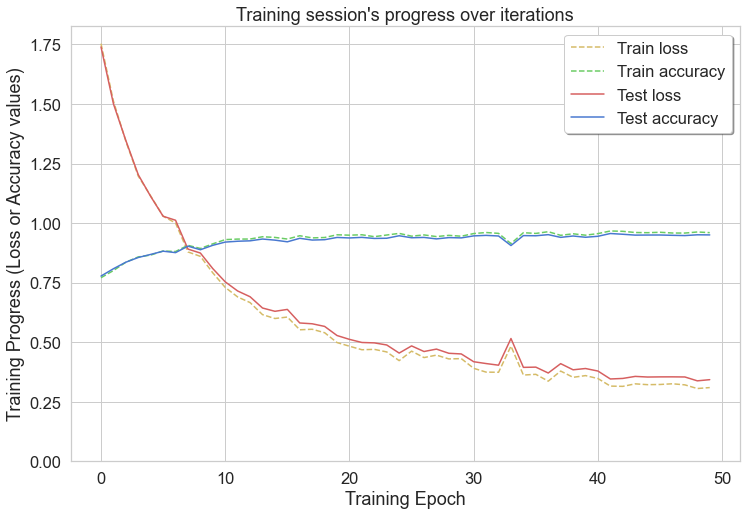

In [27]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "y--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "b-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [46]:
LABELS = ['Brush teeth','Downstairs','Jogging','Lie down','Making sandwhich','Seizure','Sitting','Sleeping', 'Standing','Upstairs','Walking','Watching Tv']



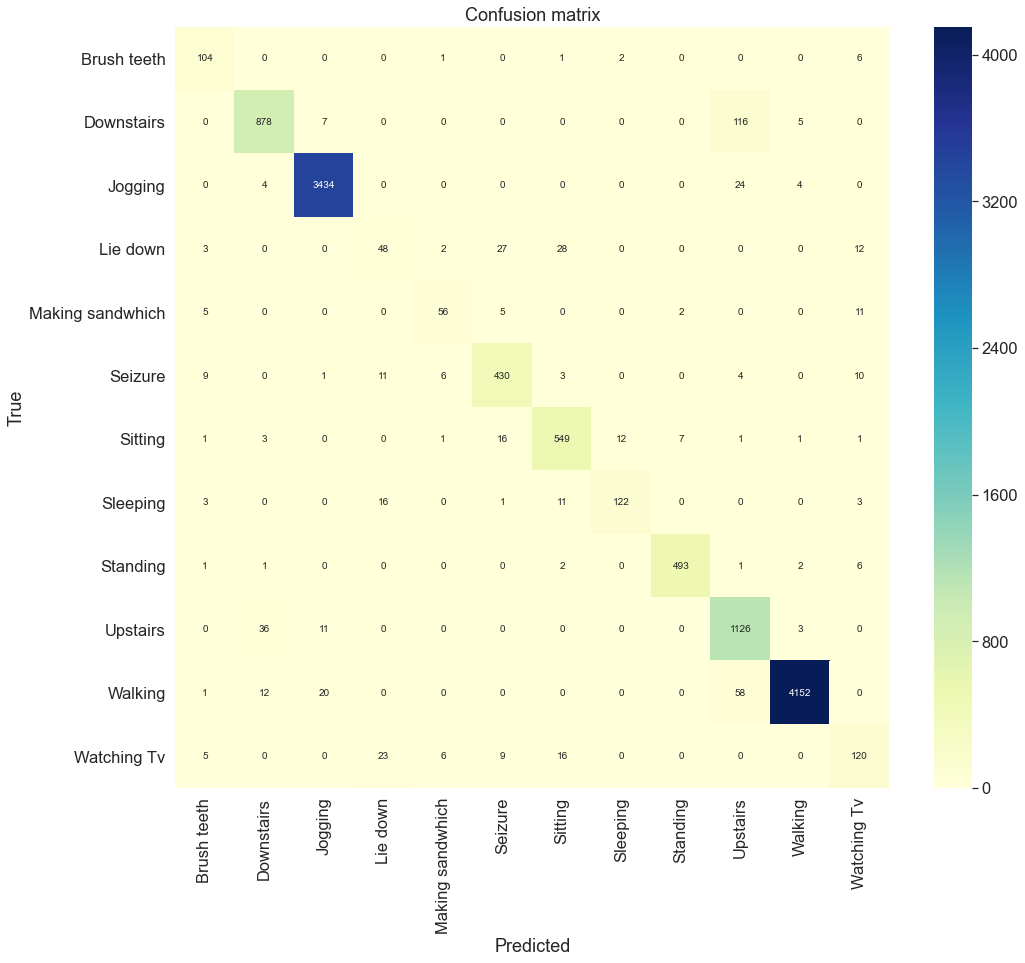

In [55]:
#Confusion Matrix,
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="YlGnBu");
plt.title("Confusion matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show();

In [56]:
# Take the class with the highest probability from the test predictions
#max_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(max_test, max_predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       114
           1       0.94      0.87      0.91      1006
           2       0.99      0.99      0.99      3466
           3       0.49      0.40      0.44       120
           4       0.78      0.71      0.74        79
           5       0.88      0.91      0.89       474
           6       0.90      0.93      0.91       592
           7       0.90      0.78      0.84       156
           8       0.98      0.97      0.98       506
           9       0.85      0.96      0.90      1176
          10       1.00      0.98      0.99      4243
          11       0.71      0.67      0.69       179

    accuracy                           0.95     12111
   macro avg       0.85      0.84      0.84     12111
weighted avg       0.95      0.95      0.95     12111

